# Averaging over a region

Although this may not sound like *real* regridding, averaging a gridded field over a region is supported by `ESMF`.  This works because the `conservative` regridding method preserves the areal average of the input field. That is, *the value at each output grid cell is the average input value over the output grid area*. Instead of mapping the input field unto rectangular outputs cells, it's mapped unto an irregular mesh defined by an outer polygon. In other words, applying the regridding weights computes the exact areal-average of the input grid over each polygon.

This process relies on converting `shapely.Polygon` and `shapely.MultiPolygon` objects into `ESMF.Mesh` objects. However, ESMF meshes do not support all features that come with  shapely's (Multi)Polyons. Indeed, mesh elements do not support interior holes, or multiple non-touching parts, as do `shapely` objects. The `xesmf.SpatialAverager` class works around these issues by computing independent weights for interior holes and multi-part geometries, before combining the weights. 

The following example shows just how simple it is to compute the average over different countries. The notebook used `geopandas`, a simple and efficient container for geometries, and `descartes` for plotting maps. Make sure both packages are installed, as they are not `xesmf` dependencies. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
import xarray as xr
import xesmf as xe

pd.set_option('display.max_rows', None)

## Simple example

In this example we'll create a synthetic global field, then compute its average over six countries. 

### Download country outlines

In [2]:
# Load some polygons from the internet
regs = gpd.read_file('https://cdn.jsdelivr.net/npm/world-atlas@2/countries-10m.json')

# Select a few countries for the sake of the example
regs = regs.iloc[[5, 9, 37, 67, 98, 155]]

# Simplify the geometries to a 0.04 deg tolerance, which is 1/50 of our grid.
# The simpler the polygons, the faster the averaging, but we lose some precision.
regs['geometry'] = regs.simplify(tolerance=0.02, preserve_topology=True)
regs

,id,name,geometry
5,032,Argentina,"MULTIPOLYGON (((-67.19287 -22.82225, -67.02727..."
9,156,China,"MULTIPOLYGON (((77.79858 35.49614, 77.66178 35..."
37,710,South Africa,"MULTIPOLYGON (((19.98200 -24.75230, 20.10800 -..."
67,724,Spain,"MULTIPOLYGON (((-5.34065 35.84736, -5.37665 35..."
98,466,Mali,"POLYGON ((-12.26352 14.77561, -12.13752 14.784..."
155,484,Mexico,"MULTIPOLYGON (((-97.13797 25.96581, -97.16677 ..."


In [3]:
# Create synthetic global data
ds = xe.util.grid_global(2, 2)
ds = ds.assign(field=xe.data.wave_smooth(ds.lon, ds.lat))
ds

<xarray.Dataset>
Dimensions:  (x: 180, x_b: 181, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon_b    (y_b, x_b) int64 -180 -178 -176 -174 -172 ... 172 174 176 178 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    field    (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0

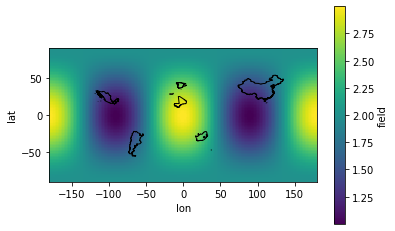

In [4]:
# Display the global field and countries' outline. 
fig, ax = plt.subplots()
ds.field.plot(ax=ax, x='lon', y='lat')
regs.plot(ax=ax, edgecolor='k', facecolor='none')

### Compute the field average over each country

`xesmf.SpatialAverager` is a class designed to average an `xarray.DataArray` over a list of polygons. It behaves similarly to `xesmf.Regridder`, but has options to deal specifically with polygon outputs. It uses the `conservative` regridding, and can store and reuse weights. 

In [5]:
savg = xe.SpatialAverager(ds, regs.geometry, geom_dim_name="country")
savg

xESMF SpatialAverager 
Weight filename:            spatialavg_90x180_6.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output list length:         6 

When called, the `SpatialAverager` instance returns a `DataArray` of averages over the `geom` dimension, here countries. `lon` and `lat` coordinates are the centroids  each polygon.

In [6]:
out = savg(ds.field)
out = out.assign_coords(country=xr.DataArray(regs["name"], dims=("country",)))
out

<xarray.DataArray 'field' (country: 6)>
array([1.58448717, 1.49195654, 2.48197742, 2.57404909, 2.89305772,
       1.26271838])
Coordinates:
    lon      (country) float64 -65.18 103.8 25.09 -3.646 -3.541 -102.5
    lat      (country) float64 -35.39 36.56 -29.0 40.23 17.35 23.95
  * country  (country) object 'Argentina' 'China' ... 'Mali' 'Mexico'
Attributes:
    regrid_method:  conservative

As the order of the polygons is conserved in the output, we can easily include the results back into our `geopandas` dataframe.

In [7]:
regs['field_avg'] = out.values
regs

,id,name,geometry,field_avg
5,032,Argentina,"MULTIPOLYGON (((-67.19287 -22.82225, -67.02727...",1.584487
9,156,China,"MULTIPOLYGON (((77.79858 35.49614, 77.66178 35...",1.491957
37,710,South Africa,"MULTIPOLYGON (((19.98200 -24.75230, 20.10800 -...",2.481977
67,724,Spain,"MULTIPOLYGON (((-5.34065 35.84736, -5.37665 35...",2.574049
98,466,Mali,"POLYGON ((-12.26352 14.77561, -12.13752 14.784...",2.893058
155,484,Mexico,"MULTIPOLYGON (((-97.13797 25.96581, -97.16677 ...",1.262718


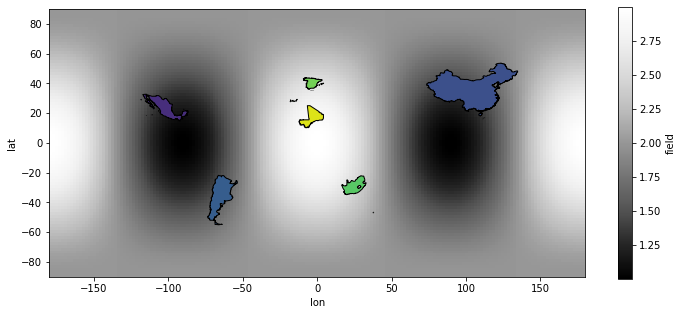

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
ds.field.plot(ax=ax, x='lon', y='lat',cmap='Greys_r')
handles = regs.plot(column='field_avg', ax=ax, edgecolor='k', vmin=1, vmax=3, cmap='viridis')

### Extract the weight mask from the averager

The weights are stored in a sparse matrix structure in `SpatialAverager.weights`. The sparse matrix can be converted to a full DataArray, but note that this will increase memory usage proportional to the number of polygons.

<Figure size 432x288 with 0 Axes>

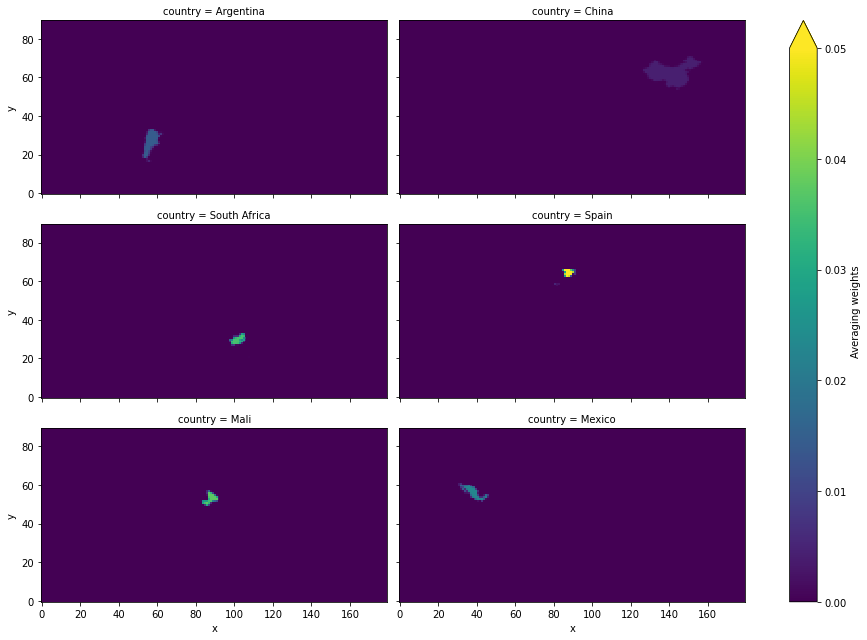

In [9]:
# Convert sparse matrix to numpy array, it has size : (n_in, n_out)
# So reshape to the same shape as ds + polygons
w = xr.DataArray(
    savg.weights.toarray().reshape(regs.geometry.size, *ds.lon.shape),
    dims=('country', *ds.lon.dims), coords=dict(country=out.country, **ds.lon.coords)
)
plt.subplots_adjust(top=0.9)
facets = w.plot(col='country', col_wrap=2, aspect=2, vmin=0, vmax=0.05)
facets.cbar.set_label("Averaging weights")

This also allows to quickly check that the weights are indeed normalized, that the sum of each mask is 1.

In [10]:
w.sum(dim=['y', 'x']).values

array([1., 1., 1., 1., 1., 1.])